https://www.tensorflow.org/tutorials/load_data/images

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.3.0


In [3]:
import pathlib

# flowers datase - 218MB
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 49s 0us/step


3670


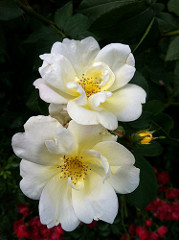

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

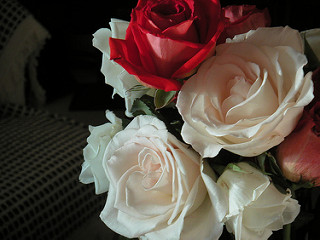

In [6]:
PIL.Image.open(str(roses[1]))

In [7]:
# keras preprocessing
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [9]:
from tensorflow.keras import layers

# [0,255] -> [0,1]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [10]:
# .cache() keeps the images in memory after they're loaded off disk during the first epoch. 
# .prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 106s 1s/step - loss: 1.3072 - accuracy: 0.4257 - val_loss: 1.0682 - val_accuracy: 0.5654
Epoch 2/3
92/92 [==============================] - 116s 1s/step - loss: 1.0209 - accuracy: 0.5923 - val_loss: 0.9904 - val_accuracy: 0.6090
Epoch 3/3
92/92 [==============================] - 122s 1s/step - loss: 0.8412 - accuracy: 0.6761 - val_loss: 0.9094 - val_accuracy: 0.6608


## Finer control on dataset

In [12]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for f in list_ds.take(5):
    print(f.numpy())

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

# split dataset to train / val
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

b'C:\\Users\\Noam\\.keras\\datasets\\flower_photos\\tulips\\14103897845_7986002615.jpg'
b'C:\\Users\\Noam\\.keras\\datasets\\flower_photos\\roses\\8692040971_826614516f_n.jpg'
b'C:\\Users\\Noam\\.keras\\datasets\\flower_photos\\dandelion\\8270191872_61e47ae3b8_m.jpg'
b'C:\\Users\\Noam\\.keras\\datasets\\flower_photos\\dandelion\\4574451859_432c856b6e_n.jpg'
b'C:\\Users\\Noam\\.keras\\datasets\\flower_photos\\daisy\\4792826628_aa5e5a9804_n.jpg'
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
2936
734


In [13]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Image shape:  (180, 180, 3)
Label:  4


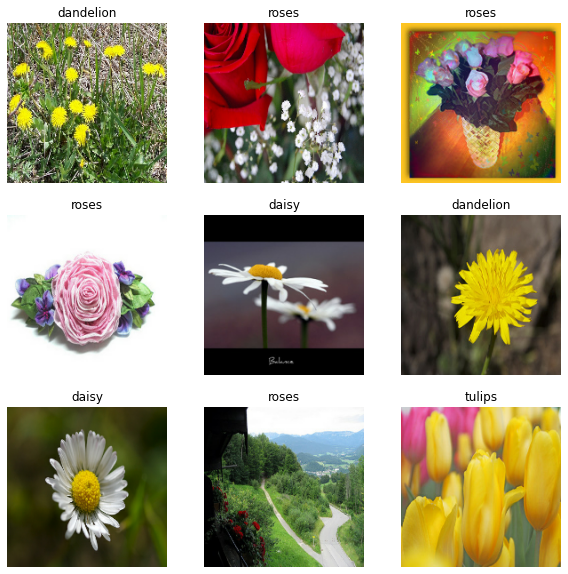

In [15]:
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [16]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 117s 1s/step - loss: 0.7139 - accuracy: 0.7313 - val_loss: 0.6551 - val_accuracy: 0.7534
Epoch 2/3
92/92 [==============================] - 115s 1s/step - loss: 0.5245 - accuracy: 0.7987 - val_loss: 0.7110 - val_accuracy: 0.7275
Epoch 3/3
92/92 [==============================] - 123s 1s/step - loss: 0.3259 - accuracy: 0.8866 - val_loss: 0.7420 - val_accuracy: 0.7289


## Using TensorFlow Datasets

Shuffling and writing examples to C:\Users\Noam\tensorflow_datasets\tf_flowers\3.0.1.incompleteT8CIDU\tf_flowers-train.tfrecord


Dataset tf_flowers downloaded and prepared to C:\Users\Noam\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.
5


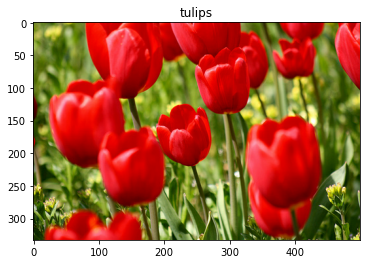

In [17]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes = metadata.features['label'].num_classes
print(num_classes)

get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)